In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import numpy as np
import gpflow

from rtgp.rtgp import RTSGPR
from rtgp.w import Shrinkage, Gaussian

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

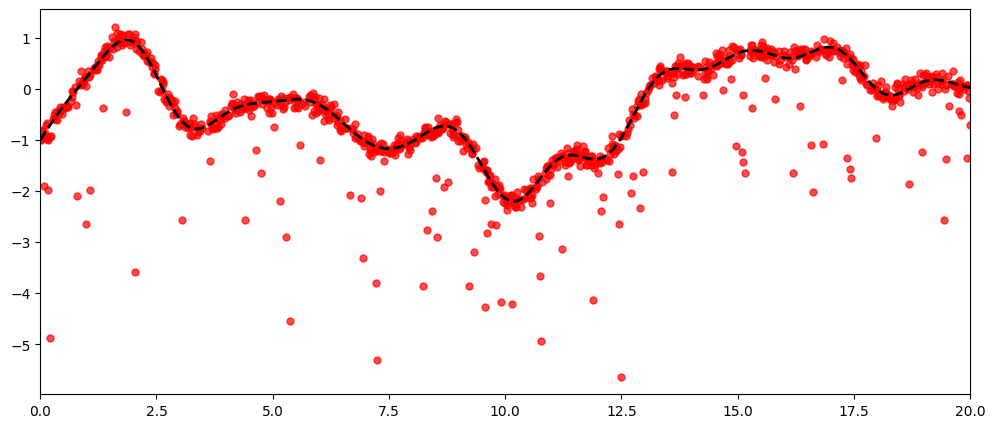

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 2000
sigma_n = 0.1
percent = 0.5
percent_miss = 0.1

kernel=gpflow.kernels.SquaredExponential()

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_obs[i_mis] = y_obs[i_mis] - np.abs(np.random.normal(scale=2, size=len(i_mis))).reshape(len(i_mis),1)

plt.plot(x, f, color='black', ls='--', lw=2, zorder = 2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7, zorder = 1)
plt.xlim(x[0], x[-1])

In [4]:
# plot estimation, obs and real data
rng = np.random.default_rng(1234)
n_inducing = 50
inducing_variable = rng.choice(x_obs, size=n_inducing, replace=False)

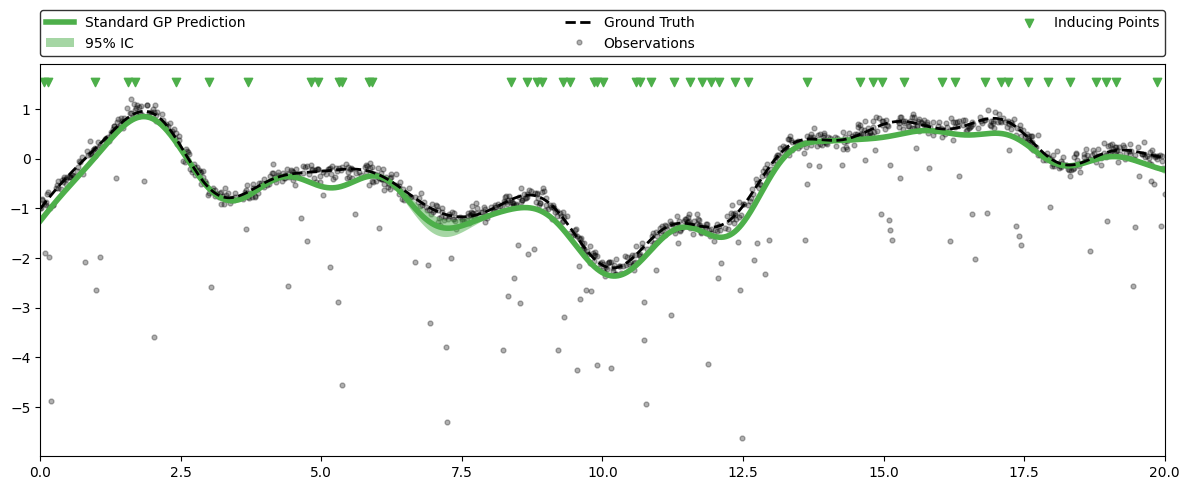

In [5]:
standard_gp = gpflow.models.SGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=sigma_n**2,
    inducing_variable = inducing_variable
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction',zorder=2)
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC',
    zorder=2)
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth', zorder = 10)
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.3, label = 'Observations', zorder =1)
ymin, ymax = plt.gca().get_ylim()
plt.scatter(standard_gp.inducing_variable.Z, ymax*np.ones_like(standard_gp.inducing_variable.Z), marker="v", c=CB_color_cycle[2], alpha=1, lw=1, label = 'Inducing Points')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()

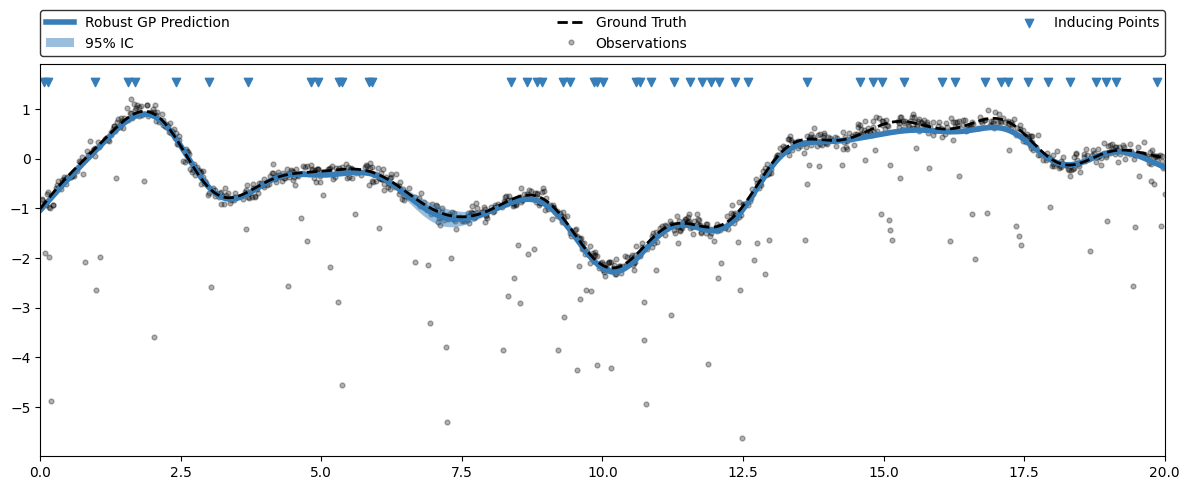

In [6]:
# plot estimation, obs and real data
dsm_gp = RTSGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    diffusion_matrix = Shrinkage(),
    noise_variance=sigma_n**2 ,
    inducing_variable = inducing_variable
)
f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)

plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction',zorder=2)
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC',
    zorder=2)


plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth', zorder = 10)
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.3, label = 'Observations', zorder =1)

ymin, ymax = plt.gca().get_ylim()
plt.scatter(dsm_gp.inducing_variable.Z, ymax*np.ones_like(dsm_gp.inducing_variable.Z), marker="v", c=CB_color_cycle[0], alpha=1, lw=1, label = 'Inducing Points')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()

# Training

In [7]:
def run_adam(model, iterations, minibatch_size=100):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure()
    optimizer = tf.optimizers.legacy.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [8]:
maxiter = 10000
lengthscale_0 = 5
variance_0 = 5
variance_n_0 =1

In [9]:
# plot estimation, obs and real data
dsm_gp = RTSGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    diffusion_matrix = Shrinkage(),
    noise_variance=sigma_n**2 ,
    inducing_variable = inducing_variable
)

gpflow.set_trainable(dsm_gp.likelihood.variance, False)

logf = run_adam(dsm_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")
gpflow.utilities.print_summary(dsm_gp)

2023-09-07 10:40:32.656914: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


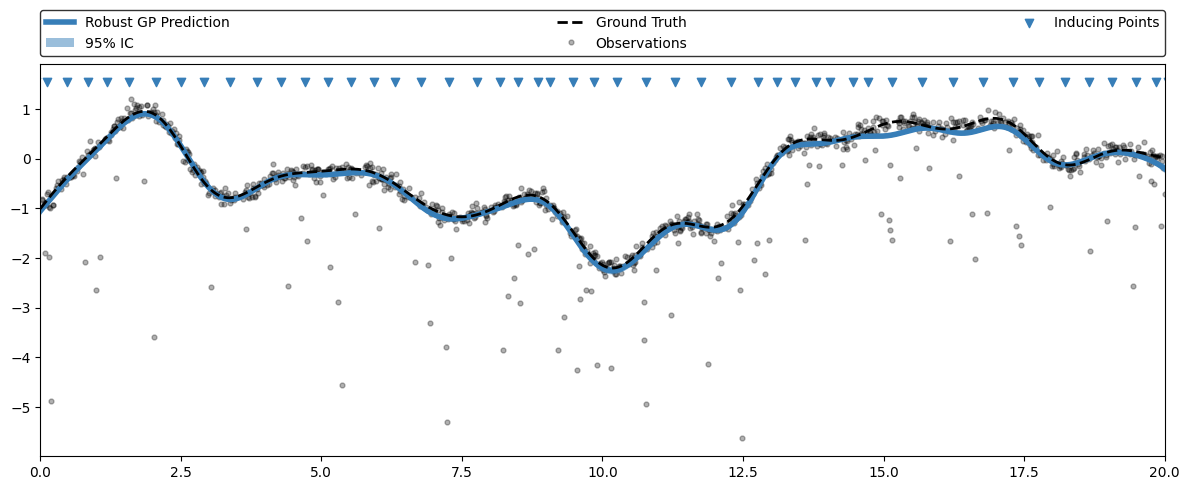

In [ ]:
# plot estimation, obs and real data
f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)

plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction',zorder=2)
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC',
    zorder=2)


plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth', zorder = 10)
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.3, label = 'Observations', zorder =1)

ymin, ymax = plt.gca().get_ylim()
plt.scatter(dsm_gp.inducing_variable.Z, ymax*np.ones_like(dsm_gp.inducing_variable.Z), marker="v", c=CB_color_cycle[0], alpha=1, lw=1, label = 'Inducing Points')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value         │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.35835       │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.54627       │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ SGPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.01          │
├──────────────────────────┼───────────┼

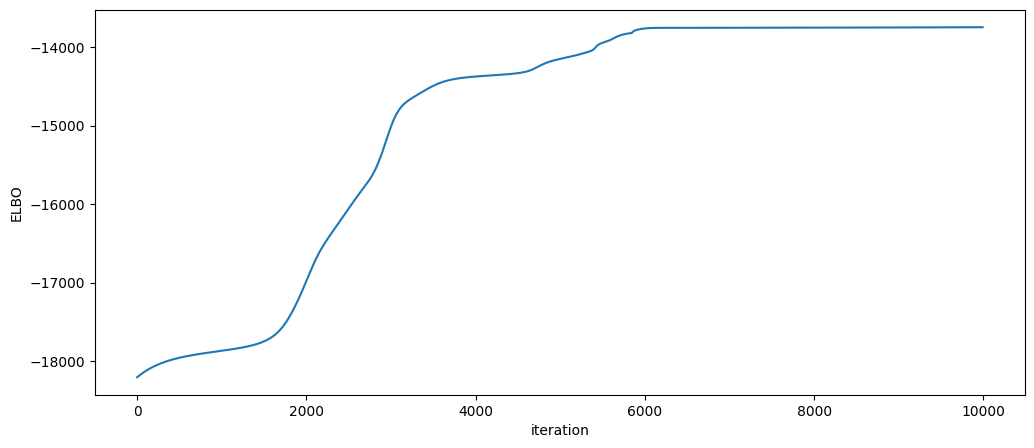

In [ ]:
# plot estimation, obs and real data
standard_gp = gpflow.models.SGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    noise_variance=sigma_n**2,
    inducing_variable = inducing_variable
)

gpflow.set_trainable(standard_gp.likelihood.variance, False)

logf = run_adam(standard_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")
gpflow.utilities.print_summary(standard_gp)

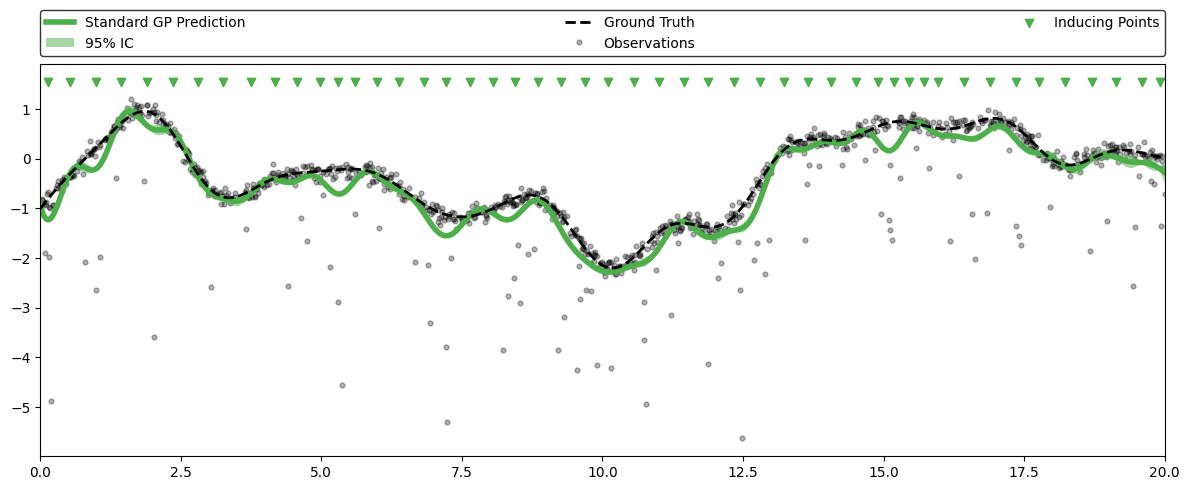

In [ ]:
f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction',zorder=2)
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC',
    zorder=2)
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth', zorder = 10)
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.3, label = 'Observations', zorder =1)
ymin, ymax = plt.gca().get_ylim()
plt.scatter(standard_gp.inducing_variable.Z, ymax*np.ones_like(standard_gp.inducing_variable.Z), marker="v", c=CB_color_cycle[2], alpha=1, lw=1, label = 'Inducing Points')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()

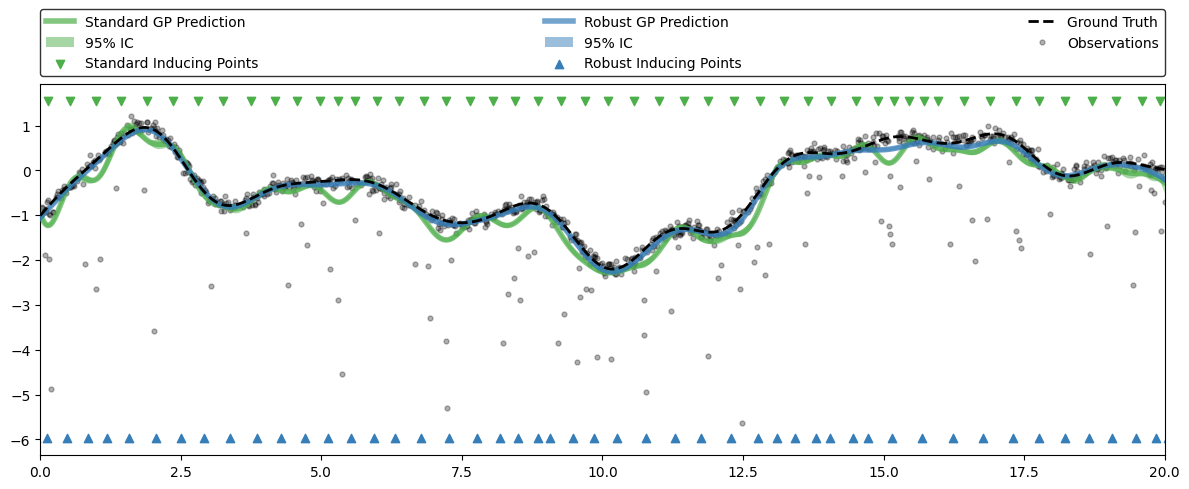

In [ ]:
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth', zorder = 10)
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.3, label = 'Observations', zorder = 1)
plt.xlim(x[0], x[-1])

ymin, ymax = plt.gca().get_ylim()

plt.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=4, alpha=0.7, label= 'Standard GP Prediction', zorder = 2)
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC',
    zorder =2)
plt.scatter(standard_gp.inducing_variable.Z, ymax*np.ones_like(standard_gp.inducing_variable.Z), marker="v", c=CB_color_cycle[2], alpha=1, lw=1, label = 'Standard Inducing Points')


plt.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], alpha=0.7, lw=4, label= 'Robust GP Prediction', zorder = 3)
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC',
    zorder = 3)

plt.scatter(dsm_gp.inducing_variable.Z, ymin*np.ones_like(dsm_gp.inducing_variable.Z), marker="^", c=CB_color_cycle[0], alpha=1, lw=1, label = 'Robust Inducing Points')

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,3,4,5,6,7,0,1]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')

plt.tight_layout()